# Practical on the use of clustering

Please start with reading task description in <a href="exercise_description.pdf">exercise_description.pdf</a>.

# Part 1: Density-based clustering
You will find concentrations of spatial events first in space and time and then in space by means of a density-based clustering algorithm <b>DBSCAN</b>.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import MDS
from sklearn.preprocessing import MinMaxScaler

import folium as fm

from IPython.core.display import Markdown, display, HTML

In [2]:
# beautify the screen display
%matplotlib inline
pd.options.display.max_columns = 200
#display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("""<style>
  .rendered_html tr, .rendered_html th,  .rendered_html td {   text-align: right; }  
  .rendered_html :first-child {   text-align: left; } 
  .rendered_html :last-child {   text-align: left; }
  </style>"""))

# Tweak default output of pyplots
screen_dpi = plt.rcParams['figure.dpi']
# 'figsize' is in inches, so convert desired default figure size in pixels into inches using the given sceen dpi 
plt.rcParams["figure.figsize"] = [800/screen_dpi,600/screen_dpi]

In [3]:
# Use in-line date string conversion/parsing, it is significantly more effective 
# than applying pd.to_datetime() on a dataframe column post-loading
def dt_parse(timestamp_str):
    return pd.to_datetime(timestamp_str, format='%Y%m%d %H:%M:%S', errors='coerce')

## Loading data
The data you will use are metadata records of geolocated flickr photos taken on the territory of the North America 
in the years from 2007 till 2016 that have keywords related to cherry blossoming in the titles or tags. 

The folder includes 3 data sets of different size:

    cherryblossom_USA_filtered.csv: 10 years of data
    cherryblossom_2012-2017.csv: 6 years of data
    cherryblossom_2012-2014.csv: 3 years of data
    
More data slows down clustering and may cause problems for visualization on some computers. We suggest you to start with the smallest dataset.

In [4]:
#events = pd.read_csv('cherryblossom_2012-2017.csv', sep=',', decimal='.', 
                      #header=0, index_col='PhotoID', parse_dates=['DateTaken'], date_parser=dt_parse)
#events = pd.read_csv('cherryblossom_USA_filtered.csv', sep=',', decimal='.', 
                      #header=0, index_col='PhotoID', parse_dates=['DateTaken'], date_parser=dt_parse)
events = pd.read_csv('cherryblossom_2012-2014.csv', sep=',', decimal='.', 
                     header=0, index_col='PhotoID', parse_dates=['DateTaken'], date_parser=dt_parse)
events.describe()

longitude     latitude          Views           prID  \
count  3337.000000  3337.000000    3337.000000    3337.000000   
mean    -92.018507    40.937699     852.043452   44814.014384   
std      21.141105     4.245330    7407.892366   34073.558563   
min    -130.595200    19.308035       1.000000       3.000000   
25%    -122.261940    38.883015      70.000000   14139.000000   
50%     -77.050598    38.969116     168.000000   37035.000000   
75%     -77.026711    43.643593     445.000000   78616.000000   
max     -52.746906    53.651505  380184.000000  110841.000000   

       Sequential number  Distance from the previous point (km)  \
count        3337.000000                             245.000000   
mean            1.498352                              54.415373   
std            12.280620                             432.935968   
min             0.000000                               1.006258   
25%             0.000000                               1.303313   
50%             0.000000                               1.588933   
75%             0.000000                               2.948318   
max           324.000000                            3935.175669   

       DateTaken: year  DateTaken: month  DateTaken: day of year  \
count      3337.000000       3337.000000             3337.000000   
mean       2012.860354          3.902307              103.014384   
std           0.763944          1.333725               39.322512   
min        2012.000000          1.000000                1.000000   
25%        2012.000000          3.000000               84.000000   
50%        2013.000000          4.000000               99.000000   
75%        2013.000000          4.000000              110.000000   
max        2014.000000         12.000000              362.000000   

       DateTaken: week of year  Days since 01/01/2007  
count              3337.000000            3337.000000  
mean                 15.343422            2243.230560  
std                   5.648646             286.767894  
min                   1.000000            1826.000000  
25%                  13.000000            1924.510000  
50%                  15.000000            2287.550000  
75%                  16.000000            2375.800000  
max                  52.000000            2896.590000

In [5]:
events.head()

Owner         UserID DateTaken   longitude  \
PhotoID                                                                  
13727525123               weiball  100374614@N05       NaT -123.195915   
9577728064       Jonathan Lederer  100438297@N07       NaT  -73.130814   
13389200105      Jonathan Lederer  100438297@N07       NaT  -73.130493   
13590066203  John Martin Andresen   10078440@N07       NaT -122.207840   
13903519904  John Martin Andresen   10078440@N07       NaT -122.205544   

              latitude           UploadDate  Views                 NAME  \
PhotoID                                                                   
13727525123  49.125679  09/04/2014 00:31:02    395         Tree of Hope   
9577728064   40.923523  23/08/2013 14:19:18     67       Cherry Blossom   
13389200105  40.924049  24/03/2014 21:12:16    102  Spring is coming...   
13590066203  47.857834  02/04/2014 21:57:54     28       SAKURA4-2-2014   
13903519904  47.855762  16/04/2014 21:44:24     22           Mill Creek   

                                                           URL  \
PhotoID                                                          
13727525123  https://farm8.staticflickr.com/7352/1372752512...   
9577728064   https://farm4.staticflickr.com/3734/9577728064...   
13389200105  https://farm8.staticflickr.com/7351/1338920010...   
13590066203  https://farm3.staticflickr.com/2853/1359006620...   
13903519904  https://farm8.staticflickr.com/7326/1390351990...   

                                                          Tags  \
PhotoID                                                          
13727525123  ;park;city;travel;vacation;sky;canada;tree;nat...   
9577728064         ;sky;nature;beautiful;pretty;cherryblossom;   
13389200105  ;pink;tree;spring;blossom;rosa;cherryblossom;b...   
13590066203                  ;sakura;cherryblossoms;millcreek;   
13903519904  ;cherryblossom;sakura;millcreek;flickrandroida...   

                                    MTags   prID  Sequential number  \
PhotoID                                                               
13727525123                           NaN  15238                  0   
9577728064                            NaN   1170                  0   
13389200105                           NaN   1169                  0   
13590066203                           NaN  12486                  0   
13903519904  flickrandroidapp:filter=none    566                  0   

             Distance from the previous point (km)  DateTaken: year  \
PhotoID                                                               
13727525123                                    NaN             2014   
9577728064                                     NaN             2013   
13389200105                                    NaN             2013   
13590066203                                    NaN             2014   
13903519904                                    NaN             2014   

             DateTaken: month DateTaken: date  DateTaken: day of year  \
PhotoID                                                                 
13727525123                 4      08.04.2014                      98   
9577728064                  5      05.05.2013                     125   
13389200105                 4      15.04.2013                     105   
13590066203                 4      02.04.2014                      92   
13903519904                 4      16.04.2014                     106   

             DateTaken: week of year  Days since 01/01/2007  
PhotoID                                                      
13727525123                       15                2654.11  
9577728064                        19                2316.68  
13389200105                       16                2296.43  
13590066203                       14                2648.62  
13903519904                       16                2662.59

## Overview of the spatial distribution: showing all events on a map

if you receive the following error message
<pre>
   IOPub data rate exceeded.
   The notebook server will temporarily stop sending output
   to the client in order to avoid crashing it.
   To change this limit, set the config variable
   `--NotebookApp.iopub_data_rate_limit`.
</pre>   
please re-start Jupyter Notebook with extra parameters:
   
   <pre>jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000</pre>
   
### For a list of available map tiles, see https://deparkes.co.uk/2016/06/10/folium-map-tiles/
   

In [6]:
lon_range = (-130.60, -52.75)
lat_range = (17.13, 53.65)
m = fm.Map(tiles='cartodbpositron', width='90%', height='90%') 
# If you adjusted the notebook display width to be as wide as your screen, the map might get very big. 
# Adjust size as desired.
m.fit_bounds([[lat_range[0], lon_range[0]], [lat_range[1], lon_range[1]]])

for id, row in events.iterrows():
    fm.CircleMarker((row.latitude, row.longitude), radius=2, color='#0000FF0D', fill=False).add_to(m)

m

## Overview of the spatio-temporal distribution in 3D (= 2D space + 1D time)

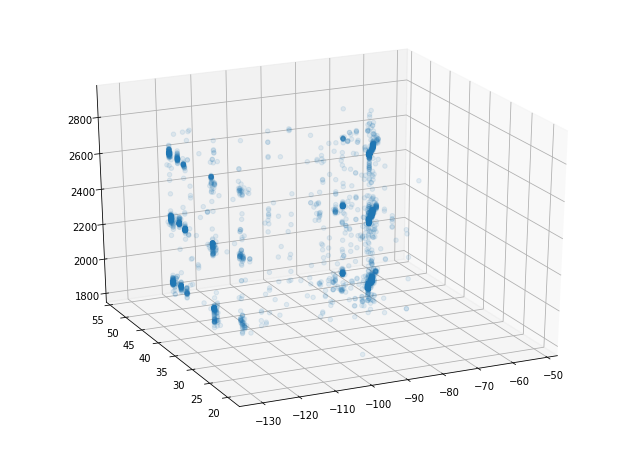

In [7]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(9, 6))

ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=25, azim=-115) # change parameters here for looking from a different perspective
ax.scatter(events['longitude'], events['latitude'], events['Days since 01/01/2007'], alpha=0.1)
plt.show()

Look at a selected single year in 3D (space + time):

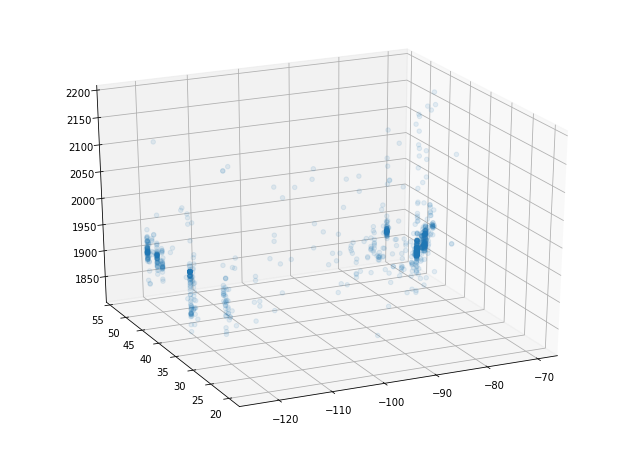

In [8]:
fig = plt.figure(1, figsize=(9, 6))
events_1year=events[events['DateTaken: year']==2012] # Change the year to see the data for another year
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=25, azim=-115) # change parameters here for looking from a different perspective
ax.scatter(events_1year['longitude'], events_1year['latitude'], events_1year['Days since 01/01/2007'], alpha=0.1)
plt.show()

#### Color Brewer's qualitative colour scale
These colours could be used for up to 12 clusters, but density-based clustering often produces much more than that.
In the following, the Color Brewer's colours are not used. Instead, colours for clusters are generated based on their positions in a spatialisation (2D projection) reflecting cluster similarities.

In [9]:
# 12-step qualitative color scale, courtesy of www.colorbrewer2.org
# These colours, however, are not used in the current code
clust_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f',
                '#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

### A function for generating colours according to positions in a 2D projection
The following function <b><i>getColor(...)</i></b> will be used for a meaningful, similarity-aware assignment of colours to clusters. The idea is to represent clusters by points in an artificial 2D space by applying a data embedding method (such as MDS - non-linear multidimensional scaling) to aggregate characteristics of clusters and generate colours for the clusters based on the positions of the corresponding points.

In [10]:
import math
def getColor (x, y, minX, maxX, minY, maxY):
    wX=maxX-minX 
    wY=maxY-minY
    rr=y-minY 
    cc=x-minX
    #print(x,y)
    if (wY < wX):   #scale vertically, i.e. modify rr
        rr *= wX/wY  
    else:           #scale horizontally, i.e. modify cc
        cc *= wY/wX
    maxD=max(wX,wY)
    rr1=maxD-rr
    cc1=maxD-cc
    #print(rr,cc,maxD,rr1,cc1)
    dc=[math.sqrt(rr*rr+cc*cc),math.sqrt(rr*rr+cc1*cc1),math.sqrt(rr1*rr1+cc*cc),math.sqrt(rr1*rr1+cc1*cc1)]
    weights=[0.0,0.0,0.0,0.0]
    for i in range(len(weights)):
        weights[i]=(maxD-dc[i])/maxD
        if (weights[i]<0):
            weights[i]=0
    #print(dc,weights)
    reds=[228,25,255,37]
    greens=[220,228,18,13]
    blues=[0,218,6,252]
    dr=0
    dg=0
    db=0
    for i,weight in enumerate(weights):
        dr += weight*reds[i]
        dg += weight*greens[i]
        db += weight*blues[i]
    if (dr<0):
        dr=0;
    if (dr>255):
        dr=255
    if (dg<0):
        dg=0;
    if (dg>255):
        dg=255        
    if (db<0):
        db=0;
    if (db>255):
        db=255  
    #print(weights,dr,dg,db)
    c_string = '#{:02x}{:02x}{:02x}'.format(int(dr),int(dg),int(db))    
    return c_string


### Preparation for DBScan clustering

In [11]:
from sklearn.cluster import DBSCAN as dbscan
import math

### Defaults for DBScan

In [12]:
kms_per_radian = 6371.0088
spatial_dist_max = 20 / kms_per_radian
temporal_dist_max = 7

### Here we define similarity measures: spatial and spatio-temporal distances 

Both use great_circle distance between two points specified by their coordinates. Note that we optimize the code for eliminating unnecessary computations of spatial distances.

In [13]:
def great_circle(lat1, long1, lat2, long2):

    # Convert latitude and longitude to 
    # spherical coordinates in radians.
    degrees_to_radians = math.pi/180.0
        
    # phi = 90 - latitude
    phi1 = (90.0 - lat1)*degrees_to_radians
    phi2 = (90.0 - lat2)*degrees_to_radians
        
    # theta = longitude
    theta1 = long1*degrees_to_radians
    theta2 = long2*degrees_to_radians
    
    # Compute spherical distance from spherical coordinates.
        
    # For two locations in spherical coordinates 
    # (1, theta, phi) and (1, theta, phi)
    # cosine( arc length ) = 
    #    sin phi sin phi' cos(theta-theta') + cos phi cos phi'
    # distance = rho * arc length
    
    cos = (math.sin(phi1)*math.sin(phi2)*math.cos(theta1 - theta2) + 
           math.cos(phi1)*math.cos(phi2))
    
    if (cos > 1.0):
        cos = 1.0

    arc = math.acos( cos )

    # Remember to multiply arc by the radius of the earth 
    # in your favorite set of units to get length.
    return arc

def SpaceDistance(x,y):
    try:
        gc_dist = great_circle(x[1],x[0],y[1],y[0])
    except ValueError:
        gc_dist = np.Infinity
    
    if (gc_dist>spatial_dist_max):
        return np.Infinity
    else:
        return gc_dist
    #return great_circle(x[1],x[0],y[1],y[0])

def SpaceTimeDistance(x,y):
    #print('Params = {},{}'.format(spatial_dist_max,temporal_dist_max))
    diff_days = math.fabs(x[2] - y[2])
    if (np.isnan(diff_days) or diff_days > temporal_dist_max):
        return np.Infinity
    
    try:
        gc_dist = great_circle(x[1],x[0],y[1],y[0])
    except ValueError:
        #print(x[1],x[0],y[1],y[0])
        gc_dist = np.Infinity
    
    if (gc_dist>spatial_dist_max):
        return np.Infinity
    
    ratio_t=diff_days/temporal_dist_max
    ratio_d=gc_dist/spatial_dist_max
    if (ratio_d>ratio_t):
        return gc_dist
    else:
        return ratio_t * spatial_dist_max

## Spatio-temporal clustering
The algorithm will find concentrations of photo-taking events in space and time based on the provided spatio-temporal distances between the events.

You are supposed to experiment with different parameter settings and investigate the impact of the clustering parameters on the results.

We have tested the following settings:
<pre>
spatial_dist_max = 30 / kms_per_radian; temporal_dist_max = 3; n_neighbours = min_samples = 3
spatial_dist_max = 30 / kms_per_radian; temporal_dist_max = 7; n_neighbours = min_samples = 3
spatial_dist_max = 20 / kms_per_radian; temporal_dist_max = 7; n_neighbours = min_samples = 3
spatial_dist_max = 20 / kms_per_radian; temporal_dist_max = 7;n_neighbours =  min_samples = 7
</pre>

<b>Please note:</b> Clustering takes time, you need to wait until the text "Clustering finished!" is printed.

In [14]:
spatial_dist_max = 25 / kms_per_radian
temporal_dist_max = 7
n_neighbours = 7

from sklearn.cluster import DBSCAN
clustered_ST = DBSCAN(metric=SpaceTimeDistance, 
                      min_samples=n_neighbours).fit(events[['longitude','latitude',
                                                            'Days since 01/01/2007']])

print("Clustering finished!")

labels=clustered_ST.labels_
unique_labels=np.unique(clustered_ST.labels_)
print('Result: {} records in the noise, labelled as -1, and {} clusters labelled as 0..{}'.
      format(events[labels==-1].shape[0], len(unique_labels)-1, len(unique_labels)-2))
#clustered
clust_id_col_name='ClusterN'
events[clust_id_col_name]=labels


Clustering finished!
Result: 981 records in the noise, labelled as -1, and 33 clusters labelled as 0..32


In [15]:
# Getting cluster sizes
cluster_sizes = events[clust_id_col_name].value_counts().rename_axis('Cluster id').to_frame('count')
print("Cluster sizes:")
print(cluster_sizes.head(15))
print("...")
print(cluster_sizes.tail(15))

cluster_sizes = cluster_sizes[cluster_sizes.index != -1] # no noise

max_cluster_size=cluster_sizes['count'].max()
print("max = ",max_cluster_size)


Cluster sizes:
            count
Cluster id       
-1            981
 4            420
 3            398
 2            253
 6            125
 10           110
 9             90
 0             87
 16            79
 15            77
 17            76
 20            63
 5             63
 11            60
 12            58
...
            count
Cluster id       
13             20
22             20
28             19
29             18
18             18
27             18
21             15
25             14
14             13
19             12
24             12
31              8
26              8
30              7
32              7
max =  420


### Characterise the clusters by computing aggregates of the data they include

In [16]:
agg_func = {
    'URL':'count',
    'Days since 01/01/2007':['max','min'],
    'longitude':['mean','max','min'],
    'latitude':['mean','max','min'],
    'DateTaken: day of year': ['mean','max','min']
}
st_aggregates = events.reset_index(drop=False)[['ClusterN','URL','Days since 01/01/2007',
                                                'longitude','latitude',
                                                'DateTaken: day of year']].groupby(['ClusterN']).agg(agg_func)
# Flatten hierarchical column names
st_aggregates.columns = ["_".join(x) for x in st_aggregates.columns.ravel()]
# compute derived attributes: duration and bounding rectangle diagonal
st_aggregates['duration (days)']=st_aggregates['Days since 01/01/2007_max']-st_aggregates['Days since 01/01/2007_min']
for id,row in st_aggregates.iterrows():
    brd=kms_per_radian*great_circle(row['latitude_max'],row['longitude_max'],row['latitude_min'],row['longitude_min'])
    #print('{}'.format(brd))
    st_aggregates.at[id,'Bound_rect_diag(km)']=brd
st_aggregates


URL_count  Days since 01/01/2007_max  Days since 01/01/2007_min  \
ClusterN                                                                    
-1              981                    2896.59                    1826.00   
 0               87                    2678.27                    2627.68   
 1               43                    2659.51                    2621.65   
 2              253                    2675.74                    2632.36   
 3              398                    2307.71                    2269.50   
 4              420                    1932.90                    1883.70   
 5               63                    2302.69                    2267.58   
 6              125                    2319.81                    2276.80   
 7               38                    2310.78                    2284.52   
 8               56                    2295.51                    2268.60   
 9               90                    2316.72                    2259.80   
 10             110                    1947.95                    1896.45   
 11              60                    2334.59                    2312.26   
 12              58                    1947.89                    1915.80   
 13              20                    2639.48                    2624.58   
 14              13                    2698.45                    2688.56   
 15              77                    2292.32                    2258.46   
 16              79                    2691.37                    2659.68   
 17              76                    1952.58                    1905.76   
 18              18                    1875.38                    1854.49   
 19              12                    1944.89                    1921.64   
 20              63                    1948.26                    1911.36   
 21              15                    1911.74                    1896.74   
 22              20                    2672.64                    2652.42   
 23              51                    1937.60                    1895.16   
 24              12                    2250.61                    2232.51   
 25              14                    1940.75                    1930.52   
 26               8                    2273.63                    2260.72   
 27              18                    2672.65                    2658.57   
 28              19                    2321.57                    2292.77   
 29              18                    1928.55                    1901.96   
 30               7                    2272.75                    2259.47   
 31               8                    2324.62                    2312.34   
 32               7                    1919.70                    1906.48   

          longitude_mean  longitude_max  longitude_min  latitude_mean  \
ClusterN                                                                
-1            -95.725042     -52.746906    -130.595200      39.911809   
 0           -123.092372    -122.809502    -123.259720      49.255782   
 1           -122.300900    -122.141884    -122.409027      47.679370   
 2            -77.041872     -76.751007     -77.281403      38.890384   
 3            -77.039387     -76.938789     -77.332863      38.886916   
 4            -77.044567     -76.961372     -77.418015      38.889991   
 5           -122.430363    -122.244629    -122.481339      37.782641   
 6            -73.995004     -73.595276     -74.457390      40.742872   
 7            -75.226992     -75.036385     -75.551003      39.971259   
 8           -122.318538    -122.283112    -122.629997      47.646405   
 9           -123.111250    -122.858650    -123.259804      49.261641   
 10           -73.979116     -73.594444     -74.275543      40.739987   
 11           -79.474963     -79.358612     -79.758186      43.648723   
 12           -79.457593     -79.315109     -79.747307      43.653145   
 13          -122.665955    -122.629723    -122.670525      45.533021

### Apply spatialisation to cluster characteristics for similarity-aware colour assignment to the clusters
We shall use spatialisation by means of a data embedding method MDS (non-linear multidimensional scaling) for obtaining a 2D spatial arrangement of the clusters and subsequent generation of colours for the clusters according to their positions in the projection. The similarity between clusters is assessed based on their spatial positions and temporal characteristics. The latter include the absolute times of cluster existence along the overall time period and the positions within the yearly cycle.<br>
<b>Please note:</b> Before doing data embedding, we need to apply normalisation to the attributes characterising the clusters because the attributes have incomparable, highly different value ranges.

-0.9736747720401729 1.1734832632331236 -1.0001210303994539 0.8360873120525084


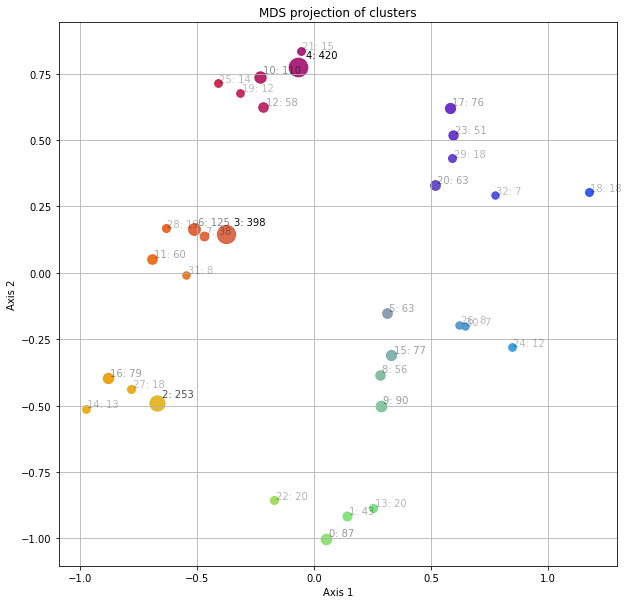

In [17]:
clusters_data = st_aggregates.loc[st_aggregates.index!=-1,
                                  ['latitude_mean','longitude_mean',
                                   'Days since 01/01/2007_min','Days since 01/01/2007_max',
                                   'DateTaken: day of year_min','DateTaken: day of year_max']]
#cl_attr.head()

scaler = MinMaxScaler()
clusters_data_scaled = scaler.fit_transform(clusters_data)

mds_ST = MDS(n_components = 2, random_state=110)
mds_ST.fit(clusters_data_scaled)
xy_mds_ST = mds_ST.fit_transform(clusters_data_scaled)

xmin_ST=xy_mds_ST[:,0].min() 
xmax_ST=xy_mds_ST[:,0].max()
ymin_ST=xy_mds_ST[:,1].min()
ymax_ST=xy_mds_ST[:,1].max()
print(xmin_ST,xmax_ST,ymin_ST,ymax_ST)

plt.figure(figsize=(10,10))
plt.xlabel('Axis 1')
plt.ylabel('Axis 2')
plt.title('MDS projection of clusters')
colors = [(0,0,0)]
for i in range(len(xy_mds_ST)):
    j=np.where(cluster_sizes.index==clusters_data.index[i])[0][0]
    r=cluster_sizes.iat[j,0]/max_cluster_size
    size=50 + 300*r
    plt.scatter(xy_mds_ST[i,0], xy_mds_ST[i,1], alpha = .9, s = size, 
                c=getColor(xy_mds_ST[i,0], xy_mds_ST[i,1],xmin_ST,xmax_ST,ymin_ST,ymax_ST))
    plt.text(xy_mds_ST[i,0]+0.0001*size, xy_mds_ST[i,1]+0.0001*size,
             str(clusters_data.index[i])+": "+str(cluster_sizes.iat[j,0]), alpha = .25+.75*r)

plt.grid()   

### See the spatial distribution of the space-time clusters on the map:

In [18]:
lon_range = (-130.60, -52.75)
lat_range = (17.13, 53.65)
m = fm.Map(tiles='cartodbpositron', width='100%', height='100%') 
# If you adjusted the notebook display width to be as wide as your screen, the map might get very big. 
#Adjust size as desired.
m.fit_bounds([[lat_range[0], lon_range[0]], [lat_range[1], lon_range[1]]])
for id, row in events.iterrows():
    cluster_id = row[clust_id_col_name]
    if cluster_id != -1 and len(np.where(clusters_data.index==cluster_id)[0])>0 :
        i=np.where(clusters_data.index==cluster_id)[0][0]
        if i<len(xy_mds_ST) :
            fm.CircleMarker((row['latitude'], row['longitude']), radius=2, 
                        #color=clust_colors[cluster_id % len(clust_colors)], 
                        color=getColor(xy_mds_ST[i,0], xy_mds_ST[i,1],xmin_ST,xmax_ST,ymin_ST,ymax_ST),
                        fill=False, opacity=.1,
                        popup='Cluster: {}'.format(cluster_id)).add_to(m) 
m

### See the spatio-temporal distribution of the space-time clusters in 3D:

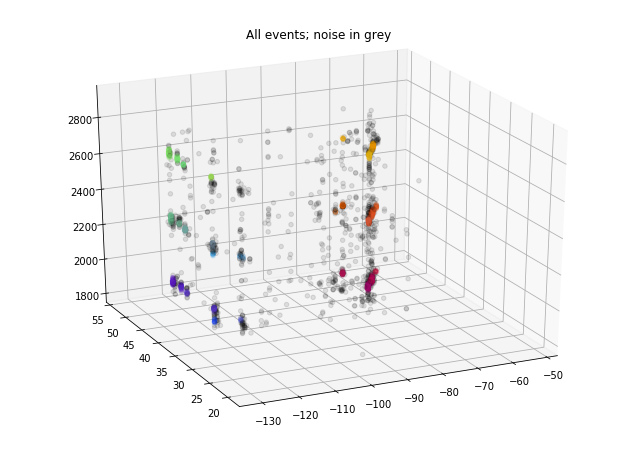

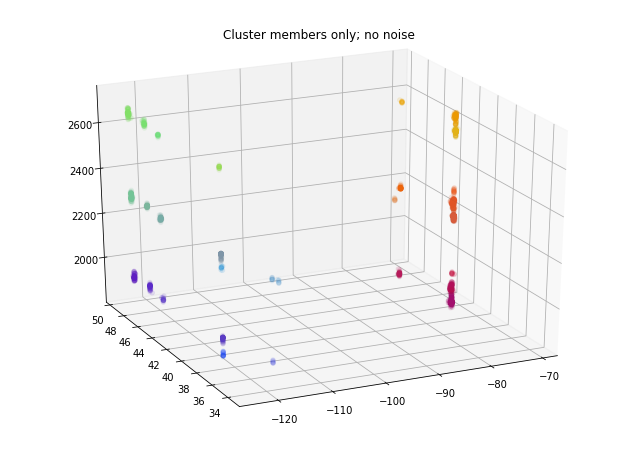

In [19]:
for id,row in events.iterrows():
    cluster_id = row[clust_id_col_name]
    if (cluster_id==-1) or len(np.where(clusters_data.index==cluster_id)[0])==0 :
        color='#000000'
    else:
        i=np.where(clusters_data.index==cluster_id)[0][0]
        color=getColor(xy_mds_ST[i,0], xy_mds_ST[i,1],xmin_ST,xmax_ST,ymin_ST,ymax_ST)
        #color=clust_colors[cluster_id % len(clust_colors)]
    events.at[id,'colors']=color

fig = plt.figure(1, figsize=(9, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=25, azim=-115) # change parameters here for experimenting
ax.scatter(events['longitude'], events['latitude'], events['Days since 01/01/2007'], c=events['colors'], alpha=0.1)
plt.title('All events; noise in grey')
plt.show()

eventsnn = events[events[clust_id_col_name] != -1] # no noise 

fig = plt.figure(2, figsize=(9, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=25, azim=-115) # change parameters here for experimenting
ax.scatter(eventsnn['longitude'], eventsnn['latitude'], eventsnn['Days since 01/01/2007'], c=eventsnn['colors'], alpha=0.1)
plt.title('Cluster members only; no noise')
plt.show()


In [20]:
## Only noise in 3D; uncomment if wish to see

#events_noise = events[events[clust_id_col_name] == -1]
#print('noise data, shape (N rows, N columns) = {}'.format(events_noise.shape))
#fig = plt.figure(1, figsize=(9, 6))
#ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=25, azim=-115) # change parameters here for experimenting
#ax.scatter(events_noise['longitude'], events_noise['latitude'], events_noise['Days since 01/01/2007'], alpha=0.1)
#plt.show()

## Task: modify the parameter settings and investigate how the changes affect the clustering results.
Experiment with the spatial and temporal distance thresholds and the minimal number of neighbours. You need to return to the cell where the parameters are set and DBSCAN is run, change the parameters, and re-run that cell and the following cells. We suggest you to modify only one parameter before each run of the clustering.

## Spatial clustering
After excluding the noise from the result of the last spatio-temporal clustering, you will apply clustering according to the spatial distances between the events, ignoring the time. Each spatial cluster will indicate a place where spatio-temporal concentrations of photo taking events occurred. <br>
For the spatial clusterig, you are supposed to use the same settings for the spatial distance threshold and the minimum number of neighbours as you used in the latest spatio-temporal clustering.

### Extract non-noise data to a new table 


Data without noise, shape (N rows, N columns) = (2356, 22)


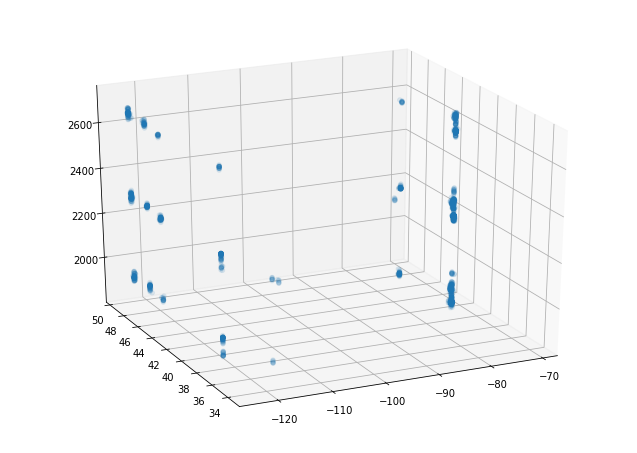

In [21]:
eventsnn = events[events[clust_id_col_name] != -1]
print('Data without noise, shape (N rows, N columns) = {}'.format(eventsnn.shape))
fig = plt.figure(1, figsize=(9, 6))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=25, azim=-115) # change parameters here for experimenting
ax.scatter(eventsnn['longitude'], eventsnn['latitude'], eventsnn['Days since 01/01/2007'], alpha=0.1)
plt.show()

### Find spatial clusters
<b>Reminder:</b> Set the same values for the spatial distance threshold and the minimum number of neighbours as you used in the latest spatio-temporal clustering. With such settings, you can expect that no noise will be produced.<br>
<b>Please note:</b> Clustering takes time, you need to wait until the text "Clustering finished!" is printed.

In [22]:
spatial_dist_max = 25 / kms_per_radian
n_neighbours = 7

clustered_S = DBSCAN(metric=SpaceDistance, min_samples=n_neighbours).fit(eventsnn[['longitude','latitude']])

print('Clustering finished!')

labels=clustered_S.labels_
unique_labels=np.unique(clustered_S.labels_)
print('Result: {} records in the noise, labelled as -1, and {} clusters labelled as 0..{}'.
      format(eventsnn[labels==-1].shape[0], len(unique_labels)-1, len(unique_labels)-2))
clust_id_col_name='ClusterNN'
eventsnn[clust_id_col_name]=labels
#clustered


Clustering finished!
Result: 0 records in the noise, labelled as -1, and 11 clusters labelled as 0..10


C:\Users\natascha\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [23]:
# Getting cluster sizes
cluster_sizes_S = eventsnn[clust_id_col_name].value_counts().rename_axis('Cluster id').to_frame('count')
print("Cluster sizes:")
print(cluster_sizes_S)

cluster_sizes_S = cluster_sizes_S[cluster_sizes_S.index != -1] # no noise

max_cluster_size_S=cluster_sizes_S['count'].max()
print("max = ",max_cluster_size_S)


Cluster sizes:
            count
Cluster id       
2            1071
4             314
0             253
3             176
1             150
6             131
7             115
5              83
8              33
9              15
11              8
10              7
max =  1071


### Characterise the clusters by computing aggregates of the data they include

In [24]:
agg_func = {
    'URL':'count',
    'Days since 01/01/2007':['max','min'],
    'longitude':['mean','max','min'],
    'latitude':['mean','max','min'],
    'DateTaken: day of year': ['mean','max','min']
}
spatial_aggregates = eventsnn.reset_index(drop=False)[['ClusterNN','URL','Days since 01/01/2007',
                                                'longitude','latitude',
                                                'DateTaken: day of year']].groupby(['ClusterNN']).agg(agg_func)
# Flatten hierarchical column names
spatial_aggregates.columns = ["_".join(x) for x in spatial_aggregates.columns.ravel()]
spatial_aggregates['duration (days)']=spatial_aggregates['Days since 01/01/2007_max']-spatial_aggregates['Days since 01/01/2007_min']
for id,row in spatial_aggregates.iterrows():
    brd=kms_per_radian*great_circle(row['latitude_max'],row['longitude_max'],row['latitude_min'],row['longitude_min'])
    spatial_aggregates.at[id,'Bound_rect_diag(km)']=brd
spatial_aggregates

URL_count  Days since 01/01/2007_max  Days since 01/01/2007_min  \
ClusterNN                                                                    
0                253                    2678.27                    1905.76   
1                150                    2659.51                    1895.16   
2               1071                    2675.74                    1883.70   
3                176                    2672.64                    1854.49   
4                314                    2691.37                    1896.45   
5                 83                    2672.65                    1896.74   
6                131                    2698.45                    1915.80   
7                115                    2639.48                    1901.96   
8                 33                    2321.57                    1930.52   
9                 15                    2273.63                    1906.48   
10                 7                    2272.75                    2259.47   
11                 8                    2324.62                    2312.34   

           longitude_mean  longitude_max  longitude_min  latitude_mean  \
ClusterNN                                                                
0             -123.107245    -122.809502    -123.272278      49.258697   
1             -122.311635    -122.128708    -122.629997      47.652199   
2              -77.042005     -76.751007     -77.418015      38.888941   
3             -122.414716    -122.126808    -122.497162      37.788178   
4              -73.984568     -73.594444     -74.457390      40.740418   
5              -75.204644     -74.965172     -75.551003      39.969248   
6              -79.464870     -79.315109     -79.758186      43.652155   
7             -122.689034    -122.528664    -122.957497      45.522606   
8              -71.097300     -70.951294     -71.139000      42.333661   
9             -118.494244    -118.480850    -118.500496      34.182517   
10            -118.027667    -118.003677    -118.167564      33.712573   
11             -83.442651     -83.388336     -83.522369      41.919240   

           latitude_max  latitude_min  DateTaken: day of year_mean  \
ClusterNN                                                            
0             49.374321     49.032112                    98.916996   
1             48.012527     47.404247                    88.820000   
2             39.138176     38.709625                    92.574230   
3             37.991570     37.593136                    95.301136   
4             41.004333     40.585789                   106.792994   
5             40.090294     39.755440                   101.337349   
6             43.872234     43.589344                   117.549618   
7             45.679882     45.294933                    83.843478   
8             42.386501     42.165947                   112.757576   
9             34.199032     34.180458                    80.733333   
10            33.771236     33.702530                    75.285714   
11            41.934998     41.909496                   125.375000   

           DateTaken: day of year_max  DateTaken: day of year_min  \
ClusterNN                                                           
0                                 127                          68   
1                                 112                          65   
2                                 119                          58   
3                                 123                          29   
4                                 135                          71   
5                                 119                          71   
6                                 143                          90   
7                                 103                          67   
8                                 130                         101   
9                                  94                          69   
10                                 81                          68   
11 

### Apply spatialisation to cluster characteristics for similarity-aware colour assignment to the clusters
Like previously for the spatio-temporal clusters, we shall use MDS for obtaining a 2D projection of the clusters and subsequent generation of colours for the clusters according to their positions in the projection.<br>
<b>Please note:</b> Before doing data embedding, we need to apply normalisation to the attributes characterising the clusters because the attributes have incomparable, highly different value ranges.

-0.5989495589601908 0.6791012543825763 -0.6234304487943928 0.6616583392696214


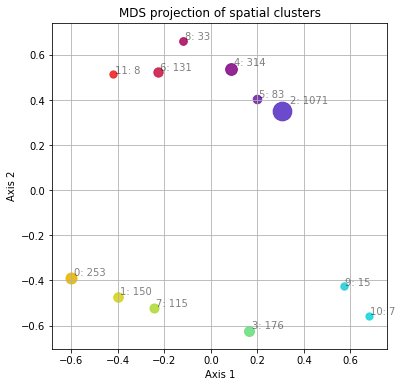

In [25]:
s_cluster_data = spatial_aggregates.loc[spatial_aggregates.index!=-1,
                                        ['latitude_mean','longitude_mean',
                                         'DateTaken: day of year_min','DateTaken: day of year_max']]
#s_cluster_data.head()

scaler = MinMaxScaler()
s_cluster_data_scaled = scaler.fit_transform(s_cluster_data)

mds_S = MDS(n_components = 2, random_state=110)
mds_S.fit(s_cluster_data_scaled)
xy_mds_S = mds_S.fit_transform(s_cluster_data_scaled)

xmin_S=xy_mds_S[:,0].min() 
xmax_S=xy_mds_S[:,0].max()
ymin_S=xy_mds_S[:,1].min()
ymax_S=xy_mds_S[:,1].max()
print(xmin_S,xmax_S,ymin_S,ymax_S)

plt.figure(figsize=(6,6))
plt.xlabel('Axis 1')
plt.ylabel('Axis 2')
plt.title('MDS projection of spatial clusters')
colors = [(0,0,0)]
for i in range(len(xy_mds_S)):
    j=np.where(cluster_sizes_S.index==s_cluster_data.index[i])[0][0]
    r=cluster_sizes_S.iat[j,0]/max_cluster_size_S
    size=50 + 300*r
    plt.scatter(xy_mds_S[i,0], xy_mds_S[i,1], alpha = .9, s = size, 
                c=getColor(xy_mds_S[i,0], xy_mds_S[i,1],xmin_S,xmax_S,ymin_S,ymax_S))
    plt.text(xy_mds_S[i,0]+0.0001*size, xy_mds_S[i,1]+0.0001*size,
             str(s_cluster_data.index[i])+": "+str(cluster_sizes_S.iat[j,0]), alpha=.5)
    
plt.grid()   

### Visualise the clusters on a map

In [26]:
m = fm.Map(tiles='cartodbpositron', width='100%', height='100%') 
# If you adjusted the notebook display width to be as wide as your screen, the map might get very big. 
# Adjust size as desired.
m.fit_bounds([[lat_range[0], lon_range[0]], [lat_range[1], lon_range[1]]])
for id, row in eventsnn.iterrows():
    cluster_id = row[clust_id_col_name]
    if (cluster_id != -1) and len(np.where(s_cluster_data.index==cluster_id)[0])>0 :
        i=np.where(s_cluster_data.index==cluster_id)[0][0]
        if i<len(xy_mds_S) :
            fm.CircleMarker((row['latitude'], row['longitude']), radius=2, 
                            #color=clust_colors[cluster_id%len(clust_colors)], 
                            color=getColor(xy_mds_S[i,0], xy_mds_S[i,1],xmin_S,xmax_S,ymin_S,ymax_S),
                            fill=False, opacity=.5,
                            popup='Cluster: {}'.format(cluster_id)).add_to(m) 
m

### Visualise the spatio-temporal distribution of the cluster members in a 3D view

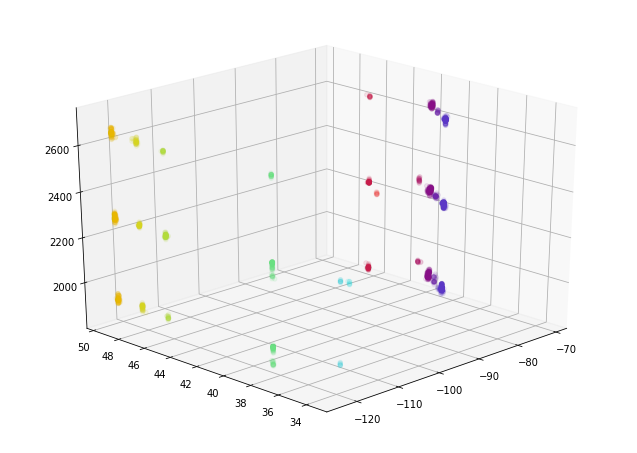

In [27]:
fig = plt.figure(1, figsize=(9, 6))
for id,row in eventsnn.iterrows():
    cluster_id = row[clust_id_col_name]
    if (cluster_id==-1) or len(np.where(s_cluster_data.index==cluster_id)[0])==0 :
        color='#000000'
    else:
        i=np.where(s_cluster_data.index==cluster_id)[0][0]
        color=getColor(xy_mds_S[i,0], xy_mds_S[i,1],xmin_S,xmax_S,ymin_S,ymax_S)
        #color=clust_colors[cluster_id % len(clust_colors)]
    eventsnn.at[id,'colors']=color
#eventsnn = events[events[clust_id_col_name] != -1] # no noise 
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=25, azim=-135) # change parameters here for experimenting
ax.scatter(eventsnn['longitude'], eventsnn['latitude'], eventsnn['Days since 01/01/2007'], 
           c=eventsnn['colors'], alpha=0.1)
plt.show()

## Task: observe how the spatial clustering has united spatio-temporal clusters that happened at different times but had close spatial locations

## Compare the times of mass photo taking in different years
You aggregate and arrange data so that you can conveniently see and compare the times and durations of cluster existence across the places and the years.
### See the differences between the years in each place
Please try to visualise these data, e.g., by bar charts.

In [28]:
agg_func = {
    'URL':'count',
    'DateTaken: day of year':['min','max']
}
st_aggregates = eventsnn.reset_index(drop=False)[['ClusterNN','DateTaken: year',
                                                  'URL','DateTaken: day of year']].groupby(['ClusterNN','DateTaken: year']).agg(agg_func)
# Flatten hierarchical column names
st_aggregates.columns = ["_".join(x) for x in st_aggregates.columns.ravel()]
st_aggregates['duration (days)']=st_aggregates['DateTaken: day of year_max']-st_aggregates['DateTaken: day of year_min']
st_aggregates

URL_count  DateTaken: day of year_min  \
ClusterNN DateTaken: year                                          
0         2012                    76                          80   
          2013                    90                          68   
          2014                    87                          71   
1         2012                    51                          70   
          2013                    56                          77   
          2014                    43                          65   
2         2012                   420                          58   
          2013                   398                          78   
          2014                   253                          76   
3         2012                    81                          29   
          2013                    75                          41   
          2014                    20                          96   
4         2012                   110                          71   
          2013                   125                          85   
          2014                    79                         103   
5         2012                    27                          71   
          2013                    38                          93   
          2014                    18                         102   
6         2012                    58                          90   
          2013                    60                         121   
          2014                    13                         132   
7         2012                    18                          76   
          2013                    77                          67   
          2014                    20                          68   
8         2012                    14                         105   
          2013                    19                         101   
9         2012                     7                          81   
          2013                     8                          69   
10        2013                     7                          68   
11        2013                     8                         121   

                           DateTaken: day of year_max  duration (days)  
ClusterNN DateTaken: year                                               
0         2012                                    127               47  
          2013                                    125               57  
          2014                                    122               51  
1         2012                                    112               42  
          2013                                    104               27  
          2014                                    103               38  
2         2012                                    107               49  
          2013                                    116               38  
          2014                                    119               43  
3         2012                                    123               94  
          2013                                    111               70  
          2014                                    116               20  
4         2012                                    122               51  
          2013                                    128               43  
          2014                                    135               32  
5         2012                                    119               48  
          2013                                    119               26  
          2014                                    116               14  
6         2012                                    122               32  
          2013                                    143               22  
          2014                                    142               10  
7         2012                                    103               27  
          2013                                    101               34  
          2014           

### See the differences between the places in each year
Please try to visualise these data, e.g., by bar charts.

In [29]:
agg_func = {
    'URL':'count',
    'DateTaken: day of year':['min','max']
}
st_aggregates = eventsnn.reset_index(drop=False)[['ClusterNN','DateTaken: year',
                                                  'URL','DateTaken: day of year']].groupby(['DateTaken: year','ClusterNN']).agg(agg_func)
# Flatten hierarchical column names
st_aggregates.columns = ["_".join(x) for x in st_aggregates.columns.ravel()]
st_aggregates['duration (days)']=st_aggregates['DateTaken: day of year_max']-st_aggregates['DateTaken: day of year_min']
st_aggregates

URL_count  DateTaken: day of year_min  \
DateTaken: year ClusterNN                                          
2012            0                 76                          80   
                1                 51                          70   
                2                420                          58   
                3                 81                          29   
                4                110                          71   
                5                 27                          71   
                6                 58                          90   
                7                 18                          76   
                8                 14                         105   
                9                  7                          81   
2013            0                 90                          68   
                1                 56                          77   
                2                398                          78   
                3                 75                          41   
                4                125                          85   
                5                 38                          93   
                6                 60                         121   
                7                 77                          67   
                8                 19                         101   
                9                  8                          69   
                10                 7                          68   
                11                 8                         121   
2014            0                 87                          71   
                1                 43                          65   
                2                253                          76   
                3                 20                          96   
                4                 79                         103   
                5                 18                         102   
                6                 13                         132   
                7                 20                          68   

                           DateTaken: day of year_max  duration (days)  
DateTaken: year ClusterNN                                               
2012            0                                 127               47  
                1                                 112               42  
                2                                 107               49  
                3                                 123               94  
                4                                 122               51  
                5                                 119               48  
                6                                 122               32  
                7                                 103               27  
                8                                 115               10  
                9                                  94               13  
2013            0                                 125               57  
                1                                 104               27  
                2                                 116               38  
                3                                 111               70  
                4                                 128               43  
                5                                 119               26  
                6                                 143               22  
                7                                 101               34  
                8                                 130               29  
                9                                  82               13  
                10                                 81               13  
                11                                133               12  
2014            0                                 122               51  
                1        

# What's next?

You have two kinds of aggregates that allow you to answer the analytical questions about (1) local dynamics in clusters and (2) dynamics of the overall spatial situations. You may use, for example, contour plots for showing isochrones of season start at a single year, see https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html 

# Partition-based clustering: in the next notebook
<a href=PB_clustering.ipynb>PB_clustering.ipynb</a> (notebook)<br>
<a href=PB_clustering.html>PB_clustering.html</a> (HTML version)